# Split lines into grid

In [2]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
import os

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection*
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import geopandas as gpd
import random
import itertools

import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
from babelgrid import Babel

from multiprocessing.pool import Pool
from functools import partial

from loguru import logger

cm = str(datetime.today().strftime("%Y%m%d%H%m"))
cm

'202108191108'

## Sample dates

Executing 50 dates to sample from jams data set

In [17]:
from src.runners.sample_jams import _sample_dates

In [20]:
df = _sample_dates(start_date = '2019-01-01', end_date = '2021-08-12')

2021-08-19 11:54:06.615 | DEBUG    | src.runners.sample_jams:_sample_dates:64 -            date
dow            
Friday       10
Monday       10
Thursday     10
Tuesday      10
Wednesday    10
2021-08-19 11:54:06.620 | DEBUG    | src.runners.sample_jams:_sample_dates:65 -       dow
year     
2019   19
2020   19
2021   12


In [21]:
print(df.date_filter[0])

20190131|20190218|20190308|20190320|20190326|20190401|20190524|20190611|20190620|20190626|20190715|20190802|20190813|20190904|20190912|20190924|20191021|20191031|20191113|20200131|20200221|20200319|20200330|20200415|20200428|20200504|20200605|20200617|20200716|20200818|20200828|20200831|20201007|20201013|20201022|20201104|20201113|20201207|20210121|20210223|20210305|20210315|20210414|20210422|20210427|20210505|20210601|20210702|20210715|20210726


## Sample lines counts

Run a query to download unique lines and number of appearance. 

- Lines 21,904,128
- Jams 507,139,112
- 50 weekdays sampled

Data is split in 6 groups to run each intersection with grids. Function `_split_groups()`. Each split contains 3,650,688 lines.

In [26]:
from src.runners.split_polygon import _get_lines

In [27]:
df_lines = _get_lines(update_data = False)

2021-08-19 12:14:43.026 | INFO     | src.runners.split_polygon:_get_lines:40 - Lines
2021-08-19 12:14:43.027 | DEBUG    | src.runners.split_polygon:_get_lines:55 - Reading lines
2021-08-19 12:14:43.028 | DEBUG    | src.runners.split_polygon:_get_lines:58 - Reading lines /home/soniame/private/projects/corona_geo_id/lines/line_wkt_count_202010712.csv
2021-08-19 12:15:57.646 | DEBUG    | src.runners.split_polygon:_get_lines:62 - Lines: 21904128


In [24]:
print(df_lines.shape)
print(sum(df_lines.count_lines))
df_lines.head(3)

(21904128, 3)
507139112


,line_wkt,count_lines,split
0,"linestring (-35.232974 -5.731801,-35.233194 -5...",26,1
1,"linestring (-103.34963 20.733682,-103.350022 2...",84,1
2,"linestring (-103.270292 20.663531,-103.270276 ...",83,1


In [25]:
from siuba import group_by, summarize, _
(df_lines
  >> group_by(_.split)
  >> summarize(lines = _.line_wkt.count())
  )

,split,lines
0,1,3650688
1,2,3650688
2,3,3650688
3,4,3650688
4,5,3650688
5,6,3650688


## Polygons definitions

5970.269755


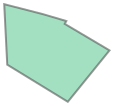

In [28]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
geometry

## Coarse grid split

In [29]:
from src.runners import split_polygon

In [30]:
# Plotting H3 cells

# H3 cells grid
tiles = Babel('h3').polyfill(geometry, resolution=1)
# S2 cells grid
#tiles = Babel('s2').polyfill(geometry, resolution=4)
len(tiles)

if False:
    tiles_gdf = gpd.GeoDataFrame([t.to_dict() for t in tiles], geometry='shapely')
    df = tiles_gdf
    m = folium.Map(location=[40.70, -73.94], zoom_start=2, tiles='CartoDB positron')
    for _, r in df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['shapely']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(m)
    m

In [31]:
tiles[0].geometry.wkt

'POLYGON ((-60.1658682739931479 3.8426199422059493, -57.8464308405491323 7.6942108739012740, -59.8349170242113928 11.3553679254903503, -63.9690486493104444 11.1489395391607751, -65.0584707543264216 9.3081116517600755, -66.1952561498043792 7.7287746080848505, -64.3282717299967430 3.8245323459248919, -60.1658682739931479 3.8426199422059493))'

In [ ]:
# Run this in 6 separated instances 
# df_coarse_split = _create_coarse_grid(df_lines, tiles, split = )

### Coarse grid union

Union of results from parallelization in 6 instances. 

- Cells: 57
- Lines: 22,214,341
- Run time per instance: 3 hrs.

In [36]:
mypath = "/home/soniame/private/projects/corona_geo_id/coarse_grid/"
csv_files = [os.path.join(mypath, x) for x in os.listdir(mypath)]
csv_files = ['/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_1.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_2.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_3.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_4.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_5.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_6.csv']
csv_files

['/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_1.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_2.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_3.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_4.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_5.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_6.csv']

In [34]:
# Append data coarse
df_coarse = pd.DataFrame()
for path_file in csv_files:
    logger.debug(path_file)
    #data_file = pd.read_csv(path_file)
    df_coarse = df_coarse.append(data_file)
    logger.debug(len(df_coarse))
    logger.debug(len(df_coarse.drop_duplicates()))

2021-08-17 13:20:10.614 | DEBUG    | __main__:<module>:3 - /home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv
2021-08-17 13:20:16.031 | DEBUG    | __main__:<module>:6 - 1175153
2021-08-17 13:20:17.472 | DEBUG    | __main__:<module>:7 - 1175153
2021-08-17 13:20:17.473 | DEBUG    | __main__:<module>:3 - /home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_1.csv
2021-08-17 13:20:48.613 | DEBUG    | __main__:<module>:6 - 4674158
2021-08-17 13:20:57.730 | DEBUG    | __main__:<module>:7 - 4670342
2021-08-17 13:20:57.731 | DEBUG    | __main__:<module>:3 - /home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_2.csv
2021-08-17 13:21:31.723 | DEBUG    | __main__:<module>:6 - 8189099
2021-08-17 13:21:50.237 | DEBUG    | __main__:<module>:7 - 8181081
2021-08-17 13:21:50.238 | DEBUG    | __main__:<module>:3 - /home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_3.csv
2021-08-17 13:22:25.592 | DEBUG    | __main__:<module>:6 - 1

In [37]:
print(df_coarse.shape)
print(df_coarse.drop_duplicates().shape)
df_coarse.head(1)

(22242051, 2)
(22214341, 2)


,line,coarse_wkt
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",POLYGON ((-77.4406988355037527 5.5631423675199...


In [38]:
# Export to csv 
coarse_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample.csv'
df_coarse.to_csv(coarse_path, index = False)

NameError: name 'df_coarse' is not defined

### Coarse grid distribution

In [68]:
df_coarse = pd.read_csv(coarse_path). \
        rename(columns = {'line':'line_wkt'})

In [70]:
print(df_coarse.shape)
print(df_coarse.coarse_wkt.nunique())
print(df_coarse.line.nunique())
df_coarse.head()

(22242051, 2)


,line_wkt,coarse_wkt
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",POLYGON ((-77.4406988355037527 5.5631423675199...
1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",POLYGON ((-99.0040860771203626 15.551320300550...
2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",POLYGON ((-89.8649065476102322 14.465456015426...
3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",POLYGON ((-99.0040860771203626 15.551320300550...
4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",POLYGON ((-76.7016783072784705 12.819508275225...


In [72]:
# Union de coarse y merge con count of jams
df_merge = df_coarse.merge(df_lines, how = 'left', on = 'line_wkt')
print(df_merge.shape)
df_merge.head()

(22242051, 4)


,line_wkt,coarse_wkt,count_lines,split
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",POLYGON ((-77.4406988355037527 5.5631423675199...,187.0,1.0
1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",POLYGON ((-99.0040860771203626 15.551320300550...,48.0,4.0
2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",POLYGON ((-89.8649065476102322 14.465456015426...,995.0,1.0
3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",POLYGON ((-99.0040860771203626 15.551320300550...,3599.0,1.0
4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",POLYGON ((-76.7016783072784705 12.819508275225...,2160.0,1.0


In [47]:
from siuba import group_by, ungroup, arrange, summarize, _

In [75]:
# Table of distribution pero H3 Cell
tab = (df_merge
  >> group_by(_.coarse_wkt)
  >> summarize(lines = _.line_wkt.count(),
               jams  = _.count_lines.sum())
  >> ungroup()
  >> arrange(-_.lines)
  )
tab.head()

,coarse_wkt,lines,jams
11,POLYGON ((-47.4611710082754144 -27.76004373820...,3568141,79118373.0
56,POLYGON ((-99.0040860771203626 15.551320300550...,2775396,73606645.0
7,POLYGON ((-39.9686027998393953 -24.39927692648...,1828350,45577900.0
42,POLYGON ((-77.4406988355037527 5.5631423675199...,1283647,38056894.0
38,POLYGON ((-73.6447470862836440 -30.42847490174...,1221259,21105746.0


In [98]:
# Export to csv 
tab.to_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv', index = False)

Plots

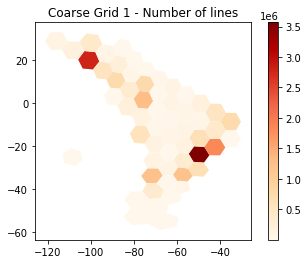

In [78]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of lines')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_LinesS1.pdf')

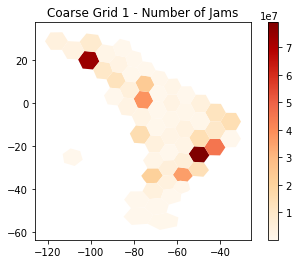

In [79]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='jams', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of Jams')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_JamsS1.pdf')

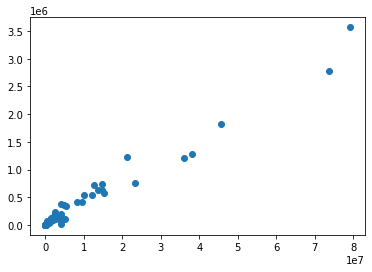

In [90]:
plt.scatter(tab.jams, tab.lines)

## Coarse grid split Big Polygons

In [137]:
from src.runners.split_polygon import _create_coarse_grid

In [138]:
tab = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv')
big_polygons = tab.sort_values(by=['lines'], ascending=False)[:6].coarse_wkt
big_polygons

0    POLYGON ((-47.4611710082754144 -27.76004373820...
1    POLYGON ((-99.0040860771203626 15.551320300550...
2    POLYGON ((-39.9686027998393953 -24.39927692648...
3    POLYGON ((-77.4406988355037527 5.5631423675199...
4    POLYGON ((-73.6447470862836440 -30.42847490174...
5    POLYGON ((-55.1640042079650925 -36.64293584360...
Name: coarse_wkt, dtype: object

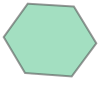

In [142]:
geometry = wkt.loads(big_polygons[0])
geometry

In [143]:
tiles_r2 = Babel('h3').polyfill(geometry, resolution=2)
len(tiles_r2)

7

In [134]:
df_new = df_coarse[df_coarse.coarse_wkt == big_polygons[0]]. \
    assign(split='R2_1')
_create_coarse_grid(df_lines = df_new, tiles = tiles_r2, split = 'R2_1')

2021-08-19 13:26:52.815 | INFO     | src.runners.split_polygon:_create_coarse_grid:98 - Create coarse grid
2021-08-19 13:26:52.816 | DEBUG    | src.runners.split_polygon:_create_coarse_grid:113 - NL: 3568141
Process ForkPoolWorker-30:
Process ForkPoolWorker-22:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Process ForkPoolWorker-23:
Process ForkPoolWorker-25:
Process ForkPoolWorker-26:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/soniame/.conda/envs/waze_

  File "/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/shapely/geometry/base.py", line 672, in is_empty
    return (self._geom is None) or bool(self.impl['is_empty'](self))
  File "/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/shapely/geos.py", line 577, in errcheck_predicate
    def errcheck_predicate(result, func, argtuple):
  File "/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/shapely/wkt.py", line 10, in loads
    return geos.WKTReader(geos.lgeos).read(data)
  File "/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/shapely/wkt.py", line 10, in loads
    return geos.WKTReader(geos.lgeos).read(data)
KeyboardInterrupt
  File "/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/shapely/topology.py", line 66, in __call__
    produc

KeyboardInterrupt: 

## Creating squares

In [73]:
from src.runners import split_polygon

In [67]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

In [72]:
df_lines = split_polygon._get_lines()

2021-08-17 17:25:44.593 | INFO     | src.runners.split_polygon:_get_lines:36 - Lines
2021-08-17 17:25:44.594 | DEBUG    | src.runners.split_polygon:_get_lines:51 - Reading lines
2021-08-17 17:27:55.475 | DEBUG    | src.runners.split_polygon:_get_lines:54 - Lines: 21904128


In [74]:
df_coarse = split_polygon._get_coarse_grid()

In [77]:
df_dist   = pd.read_csv('/home/soniame/private/projects/corona_geo_id/coarse_grid_distribution.csv')

In [ ]:
print(len(df_lines.line_wkt))
print(len(df_coarse.coarse_wkt))
print(len(df_dist))

In [ ]:
df_coarse.head()

In [86]:
df_coarse. df_dist.coarse_wkt[df_dist.lines == max(df_dist.lines)]

56    POLYGON ((-47.4611710082754144 -27.76004373820...
Name: coarse_wkt, dtype: object

In [ ]:
result = katana(geometry, 
                threshold_func = threshold_density_func, 
                threshold_value = 110000, 
                count = 100)

In [ ]:
len(result)

In [ ]:
multipolygon = MultiPolygon(result)
multipolygon

In [ ]:
grid = list()
for polygon in MultiPolygon(result):  # same for multipolygon.geoms
    grid.append(str(polygon))

In [ ]:
cm = str(datetime.today().strftime("%Y%m%d%H%m%s"))
print(cm)

In [ ]:
outdf = gpd.GeoDataFrame(columns=['geometry'])
outdf['geometry'] = grid

In [ ]:
# Export to csv 
outdf.to_csv(f"~/private/geo_id_polygon/geo_grid_area_{cm}.csv")

## Lines intersection per square



In [ ]:
def intersection_line(line, geometry):
    #print(line)
    line_wkt = wkt.loads(str(line))
    result = geometry.intersection(line_wkt)
    
    return(result)

In [ ]:
df_lines['geo_id'] = ""
#df_lines.head()

In [ ]:
for polygon in outdf.geometry:
    print(polygon)
    
    geometry = wkt.loads(polygon)
    lines = df_lines[df_lines['geo_id'] == ''].line_wkt
    if len(lines) > 0:
        # print(len(lines))
        intersect = [intersection_func(line, geometry) for line in df_lines.line_wkt]
        df_lines.loc[[x > 0 for x in intersect], 'geo_id'] = polygon
    

In [ ]:
# Export to csv
df_lines.to_csv(f"~/private/geo_id_polygon/line_wkt_area_geo_id_{cm}.csv", index = False)

### Distribution of lines/jams per square

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _
import geopandas as gpd
import folium

In [ ]:
#df_geo_id = pd.read_csv(f"/home/soniame/private/projects/corona_geo_id/intersection/geo_grid_area_geo_id_2021073017071627679286.csv")
print(df_geo_id.shape)
df_geo_id.head()

In [ ]:
tab = (df_geo_id
  >> group_by(_.geo_id)
  >> summarize(lines = _.line_wkt.count())
  >> ungroup()
  >> arrange("lines")
  )
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

tab.head()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, legend=True, cmap='OrRd')

In [ ]:
df = tab
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['lines']).add_to(geo_j)
    geo_j.add_to(m)
m

In [ ]:
#centroid = tiles[0].geometry.centroid
#m = folium.Map(location=(centroid.latitude, centroid.longitude))


In [ ]:
for tile in tiles:
    folium.GeoJson(tile.geometry.geojson).add_to(m)
m